### Predictive Modelling for Medicare Hospital Compare data: Can summary star ratings be predicted from hospital measures?

I will try to answer the above question by employing various machine learning algorithms and compare their performances. In this notebook I will demonstrate the journey and the experiments I performed on the [Medicare Hospital Compare data](https://www.medicare.gov/hospitalcompare/Data/About.html). At the end I will provide insights as to how these results can be leveraged from the perspective of the customer, e.g. a hospital owner, to derive infomative decisions. 

#### **Data**:
[<span style="color:blue">**hospitals_clean_reordered.csv**</span>](https://goo.gl/4LPE7A) is the dataset file I use in this notebook. It contains the 5 star summary star ratings under a column with the same name and 64 hospital measures, i.e. features of categorical and numerical values. The steps I took to prepare this data file out of the 32 provided original .csv files are provided and explained in the accompanied [<span style="color:green">clean_data.ipynb</span>](https://goo.gl/J2HLjB) notebook. Some explanatory data analysis alongside interesting statistical information on the data can be reviewed in the [<span style="color:green">EDA.ipynb</span>](https://goo.gl/VdDM2P) notebook. Description o fthe abbreviated column names are provided in [<span style="color:green">DataframeColumnDescription.pdf</span>](https://goo.gl/st6hDc).


In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

# Figures inline and set visualization style
%matplotlib inline
sns.set()

In [2]:
# Import data
d = os.path.dirname(os.getcwd())
data_file = os.path.join(d, 'data','processed','hospitals_clean_reordered.csv')
df_hospital = pd.read_csv(data_file)

# View first lines of data
df_hospital.head(n=4)
df_hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3490 entries, 0 to 3489
Data columns (total 65 columns):
Summary star rating                                     3490 non-null int64
State                                                   3490 non-null object
Hospital Type                                           3490 non-null object
Hospital Ownership                                      3490 non-null object
Emergency Services                                      3490 non-null object
Meets criteria for meaningful use of EHRs               3464 non-null object
Mortality national comparison                           3110 non-null object
Safety of care national comparison                      2630 non-null object
Readmission national comparison                         3240 non-null object
Effectiveness of care national comparison               3196 non-null object
Timeliness of care national comparison                  3107 non-null object
Efficient use of medical imaging national compa

#### Preparing data for sklearn
In the following cells I prepare the data for sklearn modelling toolkit. For the sake of experiment I the 2d array **X** holds only the numerical features and the array **X_all** contains all the 65 measures. There are a total of 3490 hospitals (row entry) with the following star ratings distribution:

|Summary star rating|Number of hospitals|
|-------------------|-------------------|
|<center>1</center> | <center>55</center>|
|<center>2</center> | <center>525</center>|
|<center>3</center> | <center>1380</center>|
|<center>4</center> | <center>1335</center>|
|<center>5</center> | <center>195</center>|

<span style="color:IndianRed">**Note on missing values:**</span> As can be seen from the data, there are a number of missing values. During modelling different imputation strategies will be explores to account for the missing values. Removing all the featuers with any missing value is simply not an option as we are left only with 100 datasets. On the other hand some hospital measures such as HAI_4_SIR (surgical site infection from abdominal hysterectomy) or MORT_30_CABG (death rate for coronary artery bypass graft surgery patients) have more than 50% of their values missing. Data imputation for these features might not be reasonable and I will explore with the impact of removing these features on the modelling results. 

<span style="color:IndianRed">**Note on highly correlated features:**</span> Looking at the correlation matrix from the EDA analysis, seems like there is no need to worry about highly correlated features as there are no highly (absolute Pearson-corr > 0.8) correlated features and there is only one pair with correlation above 0.7 (PST_11_POST_RESP, PSI_90_SAFETY), which describe respiratory failure after surgery and serious complications respectively. I will regardless experiment with removing one of these two and investigate the impact.

<span style="color:IndianRed">**Note on categorical features:**</span> pandas get_dummies() is used to produce a one-hot encoding of the categorical features, with the exception of the 6 natoinal level categorical features (e.g. Mortality national comparison) where a separate mapping funtion is used to respect the ordering between the feature values. 

In [3]:
# y holds the response variable- in this case this is the Summary star ratings
print(df_hospital['Summary star rating'].value_counts())
df_hospital['Summary star rating'] = df_hospital['Summary star rating']
y = pd.to_numeric(df_hospital['Summary star rating']).values
y = y.ravel()

# X hold the numerical features
df_numerics_only = df_hospital.select_dtypes(include=[np.number])
X = df_numerics_only.values
print(X)
print("Dimensions of y: {}".format(y.shape))
print("Dimension of X: {}".format(X.shape))
#df_numerics_only.info()

# Drop missing values
df_numerics_noNan = df_numerics_only.dropna()
print("df shape after dropping NaN: {}".format(df_numerics_noNan.shape))

3    1380
4    1335
2     525
5     195
1      55
Name: Summary star rating, dtype: int64
[[  3.    15.4   10.3  ...,   5.      nan    nan]
 [  4.    20.2   12.93 ...,   2.    14.    98.  ]
 [  3.    17.1     nan ...,   1.      nan    nan]
 ..., 
 [  4.      nan    nan ...,   1.     7.    94.  ]
 [  4.    14.8     nan ...,    nan  13.    97.  ]
 [  4.      nan    nan ...,    nan  10.    97.  ]]
Dimensions of y: (3490,)
Dimension of X: (3490, 48)
df shape after dropping NaN: (100, 48)


In [4]:
# Now consider the categorical variables
# X_all holds all features including categorical variables
df = df_hospital.drop('Summary star rating', axis=1)

# National categorical features are ordinal therefore a separate mapping function will be used for them
national_mapping = {'Below the national average': 1,
                    'Same as the national average': 2,
                    'Above the national average': 3}
national_features = ['Mortality national comparison',
                     'Safety of care national comparison',
                     'Readmission national comparison',
                     'Effectiveness of care national comparison',
                     'Timeliness of care national comparison',
                     'Efficient use of medical imaging national comparison']
for col in national_features:
    df[col] = df[col].map(national_mapping)

# Generate a one-hot encoding of the other categorical features
df2 = pd.get_dummies(df, drop_first=True)

X_all = df2.values
feature_names_all =  df2.columns
print("Dimensions of y: {}".format(y.shape))
print("Dimension of X_all: {}".format(X_all.shape))
print("Feature names:",feature_names_all)


Dimensions of y: (3490,)
Dimension of X_all: (3490, 121)
Feature names: Index(['Mortality national comparison', 'Safety of care national comparison',
       'Readmission national comparison',
       'Effectiveness of care national comparison',
       'Timeliness of care national comparison',
       'Efficient use of medical imaging national comparison', 'MORT_30_PN',
       'PSI_11_POST_RESP', 'PSI_6_IAT_PTX', 'PSI_13_POST_SEPSIS',
       ...
       'Hospital Ownership_Voluntary non-profit - Church',
       'Hospital Ownership_Voluntary non-profit - Other',
       'Hospital Ownership_Voluntary non-profit - Private',
       'Emergency Services_Yes', 'OP_12_Yes', 'SM_PART_NURSE_Y', 'OP_17_Yes',
       'SM_PART_GEN_SURG_Y', 'SM_SS_CHECK_Y', 'OP_25_Yes'],
      dtype='object', length=121)


In [5]:
# Additional feature arrays where the features with too many missing values are removed
def remove_missing_features(df,Threshold = 0.5):
    """
    This function returns the reduced feature array
    where the columns with missing features more than 
    a Threshold value are removed
    """
    pct_null = df.isnull().sum() / len(df)
    missing_features = pct_null[pct_null > Threshold].index
    df_tmp = df.drop(missing_features, axis=1)
    df_tmp.info()
    df_tmp = pd.get_dummies(df_tmp, drop_first=True)
    X_less = df_tmp.values
    feature_names =  df_tmp.columns
    
    return df_tmp, X_less, feature_names 


In [6]:
def remove_correlated_features(df, Threshold = 0.7):
    
    """
    This function returns the reduced feature array
    where the first column in the highly correlated 
    columns are removed
    """ 
    #df_numerics_only = df_numerics_only.apply(lambda x: x.fillna(x.mean()),axis=0)
    df_numerics_only = df_numerics_only.apply(lambda x:x.fillna(x.value_counts().index[0]))
    corr_matrix = df_numerics_only.corr().abs()
    high_corr_var=np.where(corr_matrix > Threshold)
    high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
    correlated_features =[i[0] for i in high_corr_var]
    print(correlated_features)

    df_tmp = df.drop(correlated_features, axis=1)
    X_less = df_tmp.values
    feature_names =  df_tmp.columns

    return df_tmp, X_less, feature_names

#### Dealing with imbalanced dataset
As can be seen from the above table majority of the hospitals have either rating 3 or 4. Consequently, there are not enough data for ratings 1 and 5 for the ML-based model to learn from. Consequently, I will consider a number of measures to handle the problem of imbalance dataset. I will group these into the following categories:
1. Combining class ratings. For this I combine ratings 1 and 2, and 4 and 5 together. We can view the results of the predictive modeling in this as to classify a hospital into below average rating, average rating, and abvove average rating:

|New star rating|Number of hospitals|
|-------------------|-------------------|
|<center>1</center> | <center>580</center>|
|<center>2</center> | <center>1380</center>|
|<center>3</center> | <center>1535</center>|

2. Using resampling techniques to upsample the minority classes (i.e. 1 and 4). A common algorithm to use here is [SMOTE](https://goo.gl/COC7iA) that oversamples the minority class through synthesizing samples using a k nearest neighbor approach. A combination of [oversampling and undersampling](https://goo.gl/aG1tpj) could also be tried here to decrease the impact of noisy synthetic data. 
3. There exist also variants of known classifers where a resampling techniques is integrated and will be applied during the fit time, such as [BalancedBaggingClassifier](https://goo.gl/gCALht) whicht can also be investigated here.

In [7]:
# Combine the ratings for experiment
print(df_hospital['Summary star rating'].value_counts())
df2 = df_hospital.copy()
df2.loc[:,'Summary star rating'] = df_hospital.loc[:,'Summary star rating'].replace([2, 3, 4, 5], [1, 2, 3, 3])
print(df2['Summary star rating'].value_counts())

3    1380
4    1335
2     525
5     195
1      55
Name: Summary star rating, dtype: int64
3    1530
2    1380
1     580
Name: Summary star rating, dtype: int64


In [8]:
y_three_ranks = df2['Summary star rating'].values
y_three_ranks = y_three_ranks.ravel()

In [9]:
# Some resampling techniques to address the problem of the imbalanced dataset
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import Imputer
from collections import Counter

def resample_data(X,y,scheme='SMOTE', imp_strategy='most_frequent'):
    
    X_resampled = X
    y_resampled = y
    imp = Imputer(missing_values='NaN', strategy=imp_strategy, axis=0)
    imp.fit(X)
    X_resampled = imp.transform(X)

    if scheme == 'SMOTE':
        X_resampled, y_resampled = SMOTE(random_state=0).fit_sample(X_resampled, y)
        
    elif scheme == 'ENN':
        X_resampled, y_resampled = SMOTEENN(random_state=0).fit_sample(X_resampled, y)
    
    elif scheme == 'TOMEK':
        X_resampled, y_resampled = SMOTETomek(random_state=0).fit_sample(X_resampled, y)
    
    elif scheme == 'RANDOM':
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_sample(X_resampled, y)
        
    elif scheme == 'UNDER' :
        rus = RandomUnderSampler(return_indices=True)
        X_resampled, y_resampled, idx_resampled = rus.fit_sample(X_resampled, y)
    
    
    print("Dimensions of y_ros: {}".format(y_resampled.shape))
    print("Dimension of X_ros: {}".format(X_resampled.shape))
    print(sorted(Counter(y_resampled).items()))
    
    return X_resampled, y_resampled

In [10]:
# Plot Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Modeling
<span style="color:blue">**apply_model**</span> defined below is the main function to be used for applying different classifiers to the data. It will receive a python pipeline object alongside the specific parameters of the classifier and performs a grid search with cross-validation on the training set to tune hyperparameters. The result of the performance of the model on a separate test data (unseen data) is reported in terms of accuracy and confusion-matrix. There is also a nested cross-validation feature available, which when is turned on, can be used to compare the performance between different classifers (e.g. SVM vs RandomForests). The nested cross-validation is performed on the training data and according to [Varma and Simon](https://goo.gl/oAncdJ) provides a true unbiased error of the estimate (i.e. classifier), and is therefore useful to be used when selecting between different classification algorithms. 

In [33]:
# Construct the pipeline with SVM
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, validation_curve, learning_curve, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, auc
from sklearn.linear_model import Ridge
from matplotlib.pylab import rcParams
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer, precision_score, cohen_kappa_score, f1_score, recall_score, jaccard_similarity_score, mean_squared_error, explained_variance_score, mean_squared_log_error, r2_score, mean_absolute_error 
from sklearn.preprocessing import label_binarize

#rcParams['figure.figsize'] = 20, 4
score_func = precision_score

def apply_model(X, y, pipeline, parameters, classes = ['1', '2', '3', '4', '5'], kfold = 10, scoring = score_func, 
                valid_param_name=None, grid_score = True, valid_curve = False,  learn_curve = False, classification=True, 
                train_sizes=np.linspace(.1, 1.0, 5), feature_imp=False, feature_names=feature_names_all, nested = False,
                resample = False, randomized_search = False, random_state=12):
    
    """fit the model to the data
       and print out the performance measures
    """       
    
    # Create train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    
    # Complete the steps for resampling
    #if resample:
        #X_train, y_train = resample_data(X_train,y_train,scheme='ENN', imp_strategy='most_frequent')
        
    
    inner_cv = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
    
    # Instantiate the GridSearchCV object: cv
    #StratifiedKFold(n_splits=kfold, random_state=0, shuffle=True)
    #scorer = make_scorer(score_func=precision_score, average='micro') 
    #scorer = make_scorer(score_func=cohen_kappa_score)
    scorer = make_scorer(score_func=score_func) 
    if classification:
        scorer = make_scorer(score_func=score_func, average='micro') 
       
    #scorer = make_scorer(score_func=score_func, average='micro') 
    #scorer = make_scorer(score_func=score_func, average='micro', beta=0.5)
    #cv = GridSearchCV(pipeline, parameters, scoring=scorer, cv=kfold, return_train_score=True)
    clf = GridSearchCV(pipeline, parameters, scoring=scorer, cv=inner_cv, n_jobs=4)
    if randomized_search:
        clf = RandomizedSearchCV(pipeline, parameters, scoring=scorer, cv=inner_cv, n_jobs=4)
    
    # Nested cross-validation to get an un-biased metric for model performance. 
    # This is useful to compare the performance of different Classifiers
    # This approach can also be used for selecting the winning model
    if nested: 
        outer_cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=random_state)
        nested_scores = cross_val_score(clf, X=X_train, y=y_train, cv=outer_cv, n_jobs=4, scoring=scorer)
        print("Model performance via nested cross-validaton mean score:%0.3f (+/-%0.03f)" % (np.mean(nested_scores), np.std(nested_scores)))
      

    # Fit to the training set
    clf.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = clf.predict(X_test)
    #y_pred_proba = cv.predict_proba(X_test)
    
    # Compute and print metrics
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    if classification == False: # if it"s a regression problem
        #y_pred = [np.round(y) for y in y_pred]
        y_pred = [ 1 if y < 1 else np.round(y) for y in y_pred ]
        
        
        
    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Accuracy on the test data: {}".format(accuracy * 100.0))
    #("AUC: {}".format(roc_auc_score(y_test,y_pred_proba)))
    print("Tuned model Parameters: {}".format(clf.best_params_))
    
    # Compute confusion matrix
    cnf_matrix = [[]]
    
    print(classification_report(y_test, y_pred))
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()
        
    if grid_score:
        # Grid Scores
        print('cross-validaiton scores:')
        means_valid = clf.cv_results_['mean_test_score']
        stds_valid = clf.cv_results_['std_test_score']
        for mean_valid, std_valid, params in zip(means_valid, stds_valid, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean_valid, std_valid * 2, params))
            
        print('training scores:')
        means_train = clf.cv_results_['mean_train_score']
        stds_train = clf.cv_results_['std_train_score']    
        for mean_train, std_train, params in zip(means_train, stds_train, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean_train, std_train * 2, params))
            
    if valid_curve:
        plt.title("Validation Curve")
        plt.xlabel("Parameter")
        plt.ylabel("Score")
        plt.ylim(0.0, 1.1)
        plt.semilogx(parameters[valid_param_name], means_train, label="Training score", color="r")
        plt.fill_between(parameters[valid_param_name], means_train - stds_train,
                         means_train + stds_train, alpha=0.2, color="r")
        plt.semilogx(parameters[valid_param_name], means_valid, label="Cross-validation score", color="g")
        plt.fill_between(parameters[valid_param_name], means_valid - stds_valid,
                         means_valid + stds_valid, alpha=0.2, color="g")
        plt.legend(loc="best")
        plt.show()
        
    if learn_curve:
        train_sizes, train_scores, valid_scores = learning_curve(clf, X_train, y_train, cv=kfold, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        valid_scores_mean = np.mean(valid_scores, axis=1)
        valid_scores_std = np.std(valid_scores, axis=1)
        plt.title("Learning Curve")
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        #plt.grid()
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                         valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        plt.legend(loc="best")
        
    if feature_imp:
        plt.figure()
        rcParams['figure.figsize'] = 20, 4
        feat_imp = pd.Series(cv.best_estimator_feature_importances_, feature_names).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
                
       
    return cnf_matrix, clf

In [ ]:
def apply_model_with_resampling(X, y, pipeline, parameters, classes = ['1', '2', '3', '4', '5'], 
                                random_state=[12, 20, 42], scheme = 'SMOTE'):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    
    # resample the training data
    X_train, y_train = resample_data(X_train, y_train, scheme=scheme, imp_strategy='most_frequent')
    
    clf = pipeline.set_params(parameters)
    clf.fit(X_train, y_train)
    
    # Predict the labels of the test set: y_pred
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy on the test data: {}".format(accuracy * 100.0))
    
    print(classification_report(y_test, y_pred))
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()
    
    
    

#### Dummy Classifier
I used a a dymmy classifier from sklearn to use as a reference  for judging the significance of the ML-based modeling algorithms compared to random classification lateron. Note that with all the dummy classification strategies the input data is completely ignored.

In [12]:
# Dummy Classifier (Note that with all these strategies, the predict method completely ignores the input data!)
from sklearn.dummy import DummyClassifier

strategies = ['most_frequent', 'stratified', 'prior', 'uniform']
X_resampled, y_resampled = resample_data(X_all,y,scheme='none', imp_strategy='most_frequent')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=21)

for strategy in strategies:
    clf = DummyClassifier(strategy=strategy,random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("accuracy: {}".format(clf.score(X_test, y_test))) 
    print(classification_report(y_test, y_pred))


Dimensions of y_ros: (3490,)
Dimension of X_ros: (3490, 121)
[(1, 55), (2, 525), (3, 1380), (4, 1335), (5, 195)]
accuracy: 0.3954154727793696
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        11
          2       0.00      0.00      0.00       105
          3       0.40      1.00      0.57       276
          4       0.00      0.00      0.00       267
          5       0.00      0.00      0.00        39

avg / total       0.16      0.40      0.22       698

accuracy: 0.3194842406876791
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        11
          2       0.13      0.17      0.15       105
          3       0.41      0.36      0.38       276
          4       0.40      0.40      0.40       267
          5       0.00      0.00      0.00        39

avg / total       0.33      0.32      0.33       698

accuracy: 0.3954154727793696
             precision    recall  f1-score   support

In [13]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

#### <span style="color:DarkMagenta ">**1- Classification with Ridge Regression:**</span>

I start the experimentation with regression and classification variants of a Ridge classifier from sklearn. As for the hyper paramters I will only consider the paramter \alpha to tune the regularization strength. Larger values indicate stronger regularization.
The outpur of the classifier should be self-explanatory. In short I provide the following options:
* Accuracy on a holdout set (test data)
* Confusion matrix values- This is more imprtant thatn pure accuracy as we have an imbalanced dataset
* Confuion matrix plot (diagonal elements when normlized represent the sensitivity (recall) of the model)
* [Validaiton curve](https://goo.gl/lI5d1f) with respect to a given validation parameter:
    * if both validation and training are low the model is underfitting
    * if training is high but validation is low the model is overfitting
    * otherwise it i working okay
    
* [Learning curve](https://goo.gl/lI5d1f) to investigate the impact of increasing training data:
    * if both validation and training converge to a value too low, we will not benefit much from adding more data (we would need to use a lower bias estimator)
    * if training score is much higher than the validation score, then adding more data will most probably increase generalization
    
Moreover, id the **nested** functionality is on, then a cross-validated mean score is reported for the training set.

##### Discussion:
Looking at the results of the ridge regressor for $\alpha = 215.4$, it produces an overall accuracy of $57.8\%$ and and avergae f1-score of $0.56$. Looking at the validation curve we could say that the model is probably suffering from underfitting as both the train and validation score (here $r^2$-score) are low.
    

In [ ]:
# Ridge linear regression
steps_ridge = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('ridge', Ridge(random_state=0))]
pipeline_ridge = Pipeline(steps_ridge)

parameters_ridge = {'ridge__alpha':np.logspace(-7, 5, 10)}

#print(X_all.shape)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=21)

#print(X_train.shape)
#score_func= mean_squared_error
score_func = r2_score
#score_func = explained_variance_score
apply_model(X_all, y, pipeline_ridge,  parameters_ridge, valid_param_name='ridge__alpha', scoring=score_func,
            valid_curve = 1, learn_curve = 0, classification=0, resample = False, nested = False, random_state=12)



<span style="color:DarkMagenta ">**2- Classification with Ridge Classifier:**</span>

##### Discussion:
Hypertuning on the regularization $\alpha = 10$, the classifier has a $54\%$ accuracy on the test data and an overall performance score (f1-score via nested cross-validation) of $0.55\pm 0.017$. We notice that the standard deviation is low which indicates that the model is stable. The training and validation scores are higher than Ridge regressor which implies that the model was able to capture more complexity in the data.

In [ ]:
# RidgeClassifier
steps_ridge_cls = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                 ('scaler', StandardScaler()),
                 ('ridgeClass', RidgeClassifier(random_state=0))]
pipeline_ridge_cls = Pipeline(steps_ridge_cls)

parameters_ridge_cls = {'ridgeClass__alpha':np.logspace(-7, 5, 10)}

#print(X_all.shape)

score_func= f1_score
apply_model(X_all, y, pipeline_ridge_cls,  parameters_ridge_cls, valid_param_name='ridgeClass__alpha', scoring=score_func,
            valid_curve = 1, learn_curve = 0, classification=1, nested = True, resample = False, random_state=12)

In [ ]:
# Exploring the auc scoring
from sklearn.svm import LinearSVC
model_to_set = OneVsRestClassifier(LinearSVC())

parameters = {"estimator__C": [1,2,4,8,16]}


# Create train and test sets
X_resampled, y_resampled = resample_data(X_all,y,scheme='none')
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=21)

scorer = make_scorer(score_func=auc, reorder=True) 
model_tunning = GridSearchCV(model_to_set, param_grid=parameters,
                             scoring=scorer)

model_tunning.fit(X_train, y_train)
y_pred = model_tunning.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test data: {}".format(accuracy * 100.0))
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2','3','4','5'], normalize=True,
                      title='Normalized confusion matrix')

<span style="color:DarkMagenta ">**3 - Lasso and Elastic Net Linear Regression:**</span>
##### Discussion
Looking at the results of both regressors I get accuracy of $57\%$ and average f1-score of $0.56$ for Lasso and accuracy of $55\%$ and average f1-score of $0.51$ for the elastice net regressor. Training and validaiton scores ($r^2-score$) are low in both models indicating underfitting.

Accuracy on the test data: 57.306590257879655
Tuned model Parameters: {'lasso__alpha': 0.0077426368268112772}
             precision    recall  f1-score   support

          1       1.00      0.27      0.43        11
          2       0.63      0.34      0.44       105
          3       0.52      0.67      0.59       276
          4       0.62      0.65      0.63       267
          5       1.00      0.08      0.14        39

avg / total       0.61      0.57      0.56       698

Normalized confusion matrix
[[ 0.27272727  0.54545455  0.18181818  0.          0.        ]
 [ 0.          0.34285714  0.63809524  0.01904762  0.        ]
 [ 0.          0.05434783  0.66666667  0.27898551  0.        ]
 [ 0.          0.          0.34831461  0.65168539  0.        ]
 [ 0.          0.          0.17948718  0.74358974  0.07692308]]


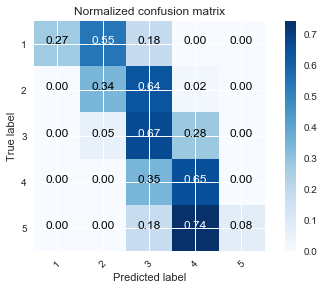

cross-validaiton scores:
0.429 (+/-0.090) for {'lasso__alpha': 9.9999999999999995e-08}
0.429 (+/-0.090) for {'lasso__alpha': 1.6681005372000591e-06}
0.429 (+/-0.090) for {'lasso__alpha': 2.782559402207126e-05}
0.430 (+/-0.089) for {'lasso__alpha': 0.00046415888336127822}
0.434 (+/-0.080) for {'lasso__alpha': 0.0077426368268112772}
0.235 (+/-0.039) for {'lasso__alpha': 0.12915496650148853}
-0.000 (+/-0.000) for {'lasso__alpha': 2.1544346900318865}
-0.000 (+/-0.000) for {'lasso__alpha': 35.938136638046402}
-0.000 (+/-0.000) for {'lasso__alpha': 599.48425031894214}
-0.000 (+/-0.000) for {'lasso__alpha': 10000.0}
training scores:
0.485 (+/-0.010) for {'lasso__alpha': 9.9999999999999995e-08}
0.485 (+/-0.010) for {'lasso__alpha': 1.6681005372000591e-06}
0.485 (+/-0.010) for {'lasso__alpha': 2.782559402207126e-05}
0.484 (+/-0.011) for {'lasso__alpha': 0.00046415888336127822}
0.474 (+/-0.010) for {'lasso__alpha': 0.0077426368268112772}
0.239 (+/-0.010) for {'lasso__alpha': 0.12915496650148853}

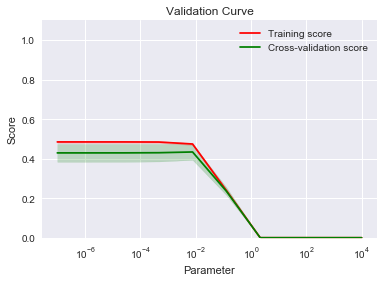

(array([[  3,   6,   2,   0,   0],
        [  0,  36,  67,   2,   0],
        [  0,  15, 184,  77,   0],
        [  0,   0,  93, 174,   0],
        [  0,   0,   7,  29,   3]], dtype=int64),
 GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=12, shuffle=True),
        error_score='raise',
        estimator=Pipeline(memory=None,
      steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
     verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=0,
    selection='cyclic', tol=0.0001, warm_start=False))]),
        fit_params=None, iid=True, n_jobs=4,
        param_grid={'lasso__alpha': array([  1.00000e-07,   1.66810e-06,   2.78256e-05,   4.64159e-04,
          7.74264e-03,   1.29155e-01,   2.15443e+00,   3.59381e+01,
          5.99484e+02,   1.00000e+04])},
        pre

In [17]:
# Lasso linear regression
steps_lasso = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('lasso', Lasso(random_state=0))]
pipeline_lasso = Pipeline(steps_lasso)

parameters_lasso = {'lasso__alpha':np.logspace(-7, 4, 10)}

score_func = r2_score
apply_model(X_all, y, pipeline_lasso, parameters_lasso, valid_param_name = 'lasso__alpha', scoring = score_func,
            learn_curve = 0, valid_curve = 1, classification=0, random_state = 12)


Accuracy on the test data: 55.014326647564474
Tuned model Parameters: {'elasticnet__l1_ratio': 9.9999999999999995e-08}
             precision    recall  f1-score   support

          1       1.00      0.09      0.17        11
          2       0.47      0.16      0.24       105
          3       0.50      0.71      0.59       276
          4       0.63      0.63      0.63       267
          5       0.00      0.00      0.00        39

avg / total       0.53      0.55      0.51       698

Normalized confusion matrix
[[ 0.09090909  0.54545455  0.36363636  0.          0.        ]
 [ 0.          0.16190476  0.82857143  0.00952381  0.        ]
 [ 0.          0.04710145  0.71376812  0.23913043  0.        ]
 [ 0.          0.          0.3670412   0.6329588   0.        ]
 [ 0.          0.          0.15384615  0.84615385  0.        ]]


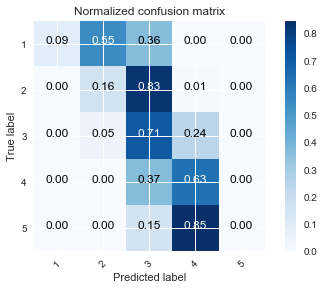

cross-validaiton scores:
0.402 (+/-0.060) for {'elasticnet__l1_ratio': 9.9999999999999995e-08}
0.402 (+/-0.060) for {'elasticnet__l1_ratio': 1.2915496650148827e-06}
0.402 (+/-0.060) for {'elasticnet__l1_ratio': 1.6681005372000593e-05}
0.402 (+/-0.060) for {'elasticnet__l1_ratio': 0.00021544346900318845}
0.399 (+/-0.060) for {'elasticnet__l1_ratio': 0.0027825594022071257}
0.345 (+/-0.051) for {'elasticnet__l1_ratio': 0.035938136638046257}
-0.000 (+/-0.000) for {'elasticnet__l1_ratio': 0.4641588833612782}
-0.000 (+/-0.000) for {'elasticnet__l1_ratio': 5.994842503189421}
-0.000 (+/-0.000) for {'elasticnet__l1_ratio': 77.426368268112782}
-0.000 (+/-0.000) for {'elasticnet__l1_ratio': 1000.0}
training scores:
0.427 (+/-0.009) for {'elasticnet__l1_ratio': 9.9999999999999995e-08}
0.427 (+/-0.009) for {'elasticnet__l1_ratio': 1.2915496650148827e-06}
0.427 (+/-0.009) for {'elasticnet__l1_ratio': 1.6681005372000593e-05}
0.427 (+/-0.009) for {'elasticnet__l1_ratio': 0.00021544346900318845}
0.422 

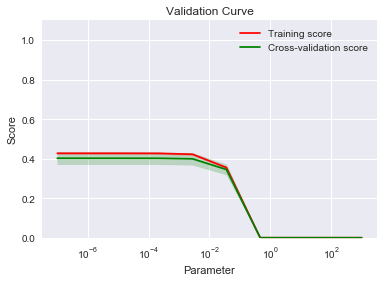

(array([[  1,   6,   4,   0,   0],
        [  0,  17,  87,   1,   0],
        [  0,  13, 197,  66,   0],
        [  0,   0,  98, 169,   0],
        [  0,   0,   6,  33,   0]], dtype=int64),
 GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=12, shuffle=True),
        error_score='raise',
        estimator=Pipeline(memory=None,
      steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
     verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=0, selection='cyclic', tol=0.0001, warm_start=False))]),
        fit_params=None, iid=True, n_jobs=4,
        param_grid={'elasticnet__l1_ratio': array([  1.00000e-07,   1.29155e-06,   1.66810e-05,   2.15443e-04,
          2.78256e-03,   3.59381e-02,   4.64159e-01,   5.99484e+00,
          7.74

In [21]:
# Elasticnet linear regression
steps_elastic = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('elasticnet', ElasticNet(random_state=0))]
pipeline_elastic = Pipeline(steps_elastic)

parameters_elastic = {'elasticnet__l1_ratio':np.logspace(-7, 3, 10)}

score_func = r2_score
apply_model(X_all, y, pipeline_elastic, parameters_elastic, valid_param_name = 'elasticnet__l1_ratio', 
            learn_curve = 0, valid_curve = 1, classification=0, random_state = 12)


<span style="color:DarkMagenta ">**4 - Classification with Logistic Regression:**</span>
##### Discussion
With the given and tuned parameters, logistic regression yields accuracy of $57\%$ and average f1-score of $0.57$. The unbiased generalization f1-score computed through nested cross-validation stays at $0.56$.

Model performance via nested cross-validaton mean score:0.559 (+/-0.022)
Accuracy on the test data: 57.73638968481375
Tuned model Parameters: {'logreg__C': 0.12915496650148853}
             precision    recall  f1-score   support

          1       0.57      0.36      0.44        11
          2       0.57      0.45      0.50       105
          3       0.55      0.55      0.55       276
          4       0.60      0.72      0.66       267
          5       0.62      0.26      0.36        39

avg / total       0.58      0.58      0.57       698

Normalized confusion matrix
[[ 0.36363636  0.54545455  0.09090909  0.          0.        ]
 [ 0.00952381  0.44761905  0.48571429  0.05714286  0.        ]
 [ 0.00362319  0.09782609  0.54710145  0.34057971  0.01086957]
 [ 0.00374532  0.00749064  0.26217228  0.71535581  0.01123596]
 [ 0.          0.02564103  0.07692308  0.64102564  0.25641026]]


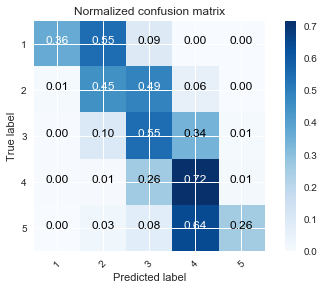

cross-validaiton scores:
0.395 (+/-0.002) for {'logreg__C': 9.9999999999999995e-08}
0.395 (+/-0.002) for {'logreg__C': 1.6681005372000591e-06}
0.531 (+/-0.035) for {'logreg__C': 2.782559402207126e-05}
0.533 (+/-0.037) for {'logreg__C': 0.00046415888336127822}
0.567 (+/-0.057) for {'logreg__C': 0.0077426368268112772}
0.569 (+/-0.057) for {'logreg__C': 0.12915496650148853}
0.558 (+/-0.048) for {'logreg__C': 2.1544346900318865}
0.554 (+/-0.051) for {'logreg__C': 35.938136638046402}
0.553 (+/-0.051) for {'logreg__C': 599.48425031894214}
0.553 (+/-0.051) for {'logreg__C': 10000.0}
training scores:
0.395 (+/-0.000) for {'logreg__C': 9.9999999999999995e-08}
0.395 (+/-0.000) for {'logreg__C': 1.6681005372000591e-06}
0.537 (+/-0.004) for {'logreg__C': 2.782559402207126e-05}
0.548 (+/-0.006) for {'logreg__C': 0.00046415888336127822}
0.618 (+/-0.005) for {'logreg__C': 0.0077426368268112772}
0.633 (+/-0.006) for {'logreg__C': 0.12915496650148853}
0.638 (+/-0.010) for {'logreg__C': 2.15443469003188

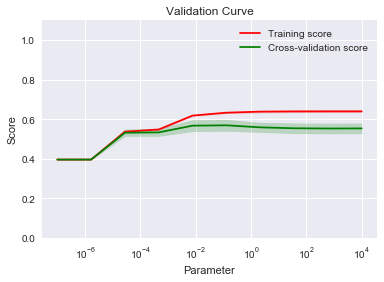

In [28]:
# Logistic regression for multiclass classification
steps_logreg = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                 ('scaler', StandardScaler()),
                 ('logreg', LogisticRegression(max_iter = 100, solver = 'newton-cg', multi_class = 'multinomial'))]
                  
pipeline_logreg = Pipeline(steps_logreg)

parameters_logreg = {'logreg__C':np.logspace(-7, 4, 10)}


score_func = f1_score

cnf_matrix, cv = apply_model(X_all, y, pipeline_logreg, parameters_logreg, valid_param_name='logreg__C', 
                             scoring = score_func, learn_curve = 0, valid_curve = 1, nested = True, 
                             classification=1, random_state = 12)

# Apply the classifier using a randomly oversampled dataset to account for the imbalanced data
#cnf_matrix, cv = apply_model(X_ros, y_ros, pipeline_logreg, parameters_logreg, 'logreg__C', 
#                             learn_curve = 1, valid_curve = 1, classification=1)

#cnf_matrix, cv = apply_model(X_smote, y_smote, pipeline_logreg, parameters_logreg, 'logreg__C', 
#                             learn_curve = 1, valid_curve = 1, classification=1)


<span style="color:DarkMagenta ">**5 - Ordinal logistic regression using Mord:**</span>

Here I used the logistic regression provided by mord python package for ordinal regression. Ordinal regression (also called "ordinal classification") is a type of regression analysis used for predicting an ordinal variable, i.e. a variable whose value exists on an arbitrary scale where only the relative ordering between different values is significant. As in my probelm I have a discrete 5-star rating, it can also be modeled by a regressor suitable to predict discrete outcomes. for this purpose [mord](https://goo.gl/hcMkYP) provides a collection of ordinal regression algorithms in Python, following a scikit-learn compatible API.
##### Discussion
Accuracy on the test data is at $58.4%$ and the average f1-score of $0.57$. Over performance score from nested cross-validation is $0.57 \pm 0.025.$

Model performance via nested cross-validaton mean score:0.569 (+/-0.025)
Accuracy on the test data: 58.45272206303726
Tuned model Parameters: {'logclassmord__alpha': 35.938136638046402}
             precision    recall  f1-score   support

          1       0.75      0.27      0.40        11
          2       0.61      0.40      0.48       105
          3       0.55      0.59      0.57       276
          4       0.61      0.74      0.67       267
          5       1.00      0.08      0.14        39

avg / total       0.61      0.58      0.57       698

Normalized confusion matrix
[[ 0.27272727  0.63636364  0.          0.09090909  0.        ]
 [ 0.00952381  0.4         0.57142857  0.01904762  0.        ]
 [ 0.          0.07246377  0.58695652  0.34057971  0.        ]
 [ 0.          0.          0.25842697  0.74157303  0.        ]
 [ 0.          0.          0.1025641   0.82051282  0.07692308]]


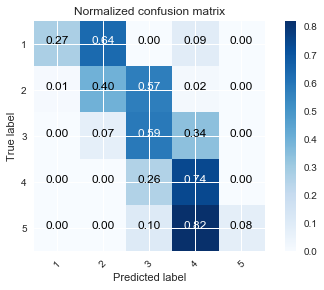

cross-validaiton scores:
0.570 (+/-0.068) for {'logclassmord__alpha': 9.9999999999999995e-08}
0.571 (+/-0.067) for {'logclassmord__alpha': 1.6681005372000591e-06}
0.571 (+/-0.067) for {'logclassmord__alpha': 2.782559402207126e-05}
0.571 (+/-0.067) for {'logclassmord__alpha': 0.00046415888336127822}
0.571 (+/-0.067) for {'logclassmord__alpha': 0.0077426368268112772}
0.571 (+/-0.067) for {'logclassmord__alpha': 0.12915496650148853}
0.569 (+/-0.062) for {'logclassmord__alpha': 2.1544346900318865}
0.573 (+/-0.065) for {'logclassmord__alpha': 35.938136638046402}
0.557 (+/-0.053) for {'logclassmord__alpha': 599.48425031894214}
0.530 (+/-0.046) for {'logclassmord__alpha': 10000.0}
training scores:
0.597 (+/-0.010) for {'logclassmord__alpha': 9.9999999999999995e-08}
0.597 (+/-0.010) for {'logclassmord__alpha': 1.6681005372000591e-06}
0.597 (+/-0.010) for {'logclassmord__alpha': 2.782559402207126e-05}
0.597 (+/-0.010) for {'logclassmord__alpha': 0.00046415888336127822}
0.597 (+/-0.010) for {'lo

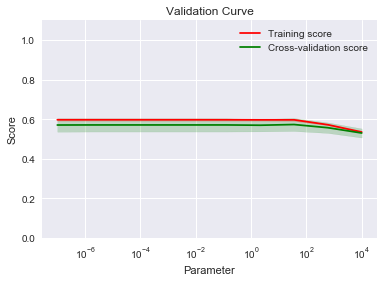

(array([[  3,   7,   0,   1,   0],
        [  1,  42,  60,   2,   0],
        [  0,  20, 162,  94,   0],
        [  0,   0,  69, 198,   0],
        [  0,   0,   4,  32,   3]], dtype=int64),
 GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=12, shuffle=True),
        error_score='raise',
        estimator=Pipeline(memory=None,
      steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
     verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logclassmord', LogisticIT(alpha=1.0, max_iter=100, verbose=0))]),
        fit_params=None, iid=True, n_jobs=4,
        param_grid={'logclassmord__alpha': array([  1.00000e-07,   1.66810e-06,   2.78256e-05,   4.64159e-04,
          7.74264e-03,   1.29155e-01,   2.15443e+00,   3.59381e+01,
          5.99484e+02,   1.00000e+04])},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=make_scorer(f1_score, average=micro), verbose=0))

In [36]:
# Ordindal regression using the mord package
import mord as m

steps_logclassmord = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                      ('scaler', StandardScaler()),
                      ('logclassmord', m.LogisticIT(max_iter = 100))]
                  
pipeline_logclassmord = Pipeline(steps_logclassmord)

parameters_logclassmord = {'logclassmord__alpha':np.logspace(-7, 4, 10)}

score_func = f1_score
#score_func = cohen_kappa_score
apply_model(X_all, y, pipeline_logclassmord, parameters_logclassmord, valid_param_name = 'logclassmord__alpha', 
            learn_curve = 0, valid_curve = 1, classification=1, nested = True, scoring = score_func,
            random_state = 12)

<span style="color:DarkMagenta ">**6 - Linear classification with support vector classifier:**</span>
##### Discussion
The reported accuracy on the test data is $55\%$ and the avergae f1-score is at $$. The overl generalization performance considerinf the f1-score is at $ \pm $.

Model performance via nested cross-validaton mean score:0.555 (+/-0.022)
Accuracy on the test data: 55.014326647564474
Tuned model Parameters: {'lsvc__C': 0.001}
             precision    recall  f1-score   support

          1       1.00      0.09      0.17        11
          2       0.52      0.36      0.43       105
          3       0.53      0.54      0.53       276
          4       0.57      0.72      0.64       267
          5       0.56      0.13      0.21        39

avg / total       0.55      0.55      0.53       698

Normalized confusion matrix
[[ 0.09090909  0.72727273  0.09090909  0.          0.09090909]
 [ 0.          0.36190476  0.56190476  0.07619048  0.        ]
 [ 0.          0.08695652  0.53985507  0.36956522  0.00362319]
 [ 0.          0.00749064  0.26966292  0.71535581  0.00749064]
 [ 0.          0.02564103  0.02564103  0.82051282  0.12820513]]


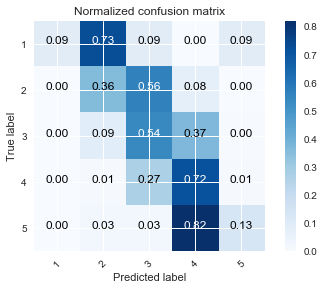

cross-validaiton scores:
0.535 (+/-0.057) for {'lsvc__C': 9.9999999999999995e-08}
0.536 (+/-0.060) for {'lsvc__C': 2.1544346900318822e-06}
0.555 (+/-0.042) for {'lsvc__C': 4.6415888336127723e-05}
0.560 (+/-0.055) for {'lsvc__C': 0.001}
0.556 (+/-0.047) for {'lsvc__C': 0.021544346900318822}
0.547 (+/-0.039) for {'lsvc__C': 0.46415888336127725}
0.486 (+/-0.064) for {'lsvc__C': 10.0}
0.438 (+/-0.061) for {'lsvc__C': 215.44346900318777}
0.439 (+/-0.057) for {'lsvc__C': 4641.5888336127728}
0.441 (+/-0.068) for {'lsvc__C': 100000.0}
training scores:
0.555 (+/-0.007) for {'lsvc__C': 9.9999999999999995e-08}
0.557 (+/-0.008) for {'lsvc__C': 2.1544346900318822e-06}
0.579 (+/-0.008) for {'lsvc__C': 4.6415888336127723e-05}
0.607 (+/-0.008) for {'lsvc__C': 0.001}
0.613 (+/-0.009) for {'lsvc__C': 0.021544346900318822}
0.619 (+/-0.009) for {'lsvc__C': 0.46415888336127725}
0.538 (+/-0.023) for {'lsvc__C': 10.0}
0.482 (+/-0.056) for {'lsvc__C': 215.44346900318777}
0.487 (+/-0.031) for {'lsvc__C': 4641.

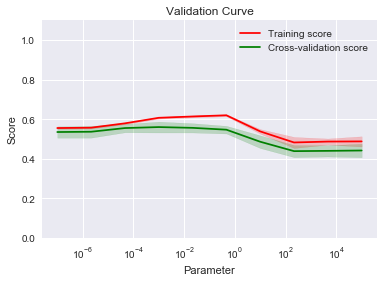

In [43]:
# Now try a linear classification using the support vector classifier
from sklearn.svm import LinearSVC

steps_lsvc = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('lsvc', LinearSVC(random_state=0, loss = 'squared_hinge'))]
pipeline_lsvc = Pipeline(steps_lsvc)

parameters_lsvc = {#'lsvc__loss':['hinge','squared_hinge']}
                   'lsvc__C':np.logspace(-7,5,10)}

# I see worse resutls on the test data when doing cross-validation. Perhaps I should do nexted cross-validation to get unbiased 
# prediction result on the test data? For example the default of C is one, but if I set it through gridsearch I get seemingly 
# worse results -->  Need to do exhaustive search, i.e., over a range. Look into this more closely however.

# Report results for different scoring
#score_func = precision_score
score_func = f1_score
#score_func = recall_score
#score_func = fbeta_score
#score_func = jaccard_similarity_score

cnf_matrix, cv = apply_model(X_all, y, pipeline_lsvc, parameters_lsvc, scoring = score_func, 
                             valid_param_name = 'lsvc__C', valid_curve=1, learn_curve = 0, 
                             nested = True, classification=1, random_state = 12)



In [ ]:
# Now usig the combined rankings
cnf_matrix, cv = apply_model(X_all, y_three_ranks, pipeline_lsvc, parameters_lsvc, learn_curve = 1, classification=1)

# Plot the confusion matrix
class_names = ['1', '2', '3']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [44]:
<span style="color:DarkMagenta ">**6 - Random Forest Classification:**</span>

SyntaxError: invalid syntax (<ipython-input-44-83623a1e0064>, line 1)

In [ ]:
# Random Forest Regression (Plot the feature importance)-- It chooses the auto one. Which means all the features. And it is basically bagging.
from sklearn.ensemble import RandomForestRegressor

steps_rfrg = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('rfrg', RandomForestRegressor(random_state=0, class_weight = 'balanced'))]
pipeline_rfrg = Pipeline(steps_rfrg)

parameters_rfrg = {'rfrg__max_depth':[16, 32],
                   'rfrg__n_estimators':[160, 180, 200],
                   'rfrg__max_features':["auto", "sqrt", "log2"]}

cnf_matrix, cv = apply_model(X_all, y, pipeline_rfrg, parameters_rfrg, classification=0)


In [ ]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier

steps_rfcl = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('rfcl', RandomForestClassifier(random_state=0, class_weight = 'balanced'))]
pipeline_rfcl = Pipeline(steps_rfcl)

parameters_rfcl = {'rfcl__max_depth':np.arange(2,128, 20),
                   'rfcl__n_estimators':np.arange(10,200, 10),
                   'rfcl__max_features':["auto", "sqrt", "log2"]}

cnf_matrix, cv = apply_model(X_all, y, pipeline_rfcl, parameters_rfcl, valid_param_name='rfcl__max_depth', 
                             valid_curve = 0, learn_curve = 0, classification=1)

# Plot the confusion matrix
class_names = ['1', '2', '3', '4', '5']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# GBM Classifers (Gradient Boosting)
# The overall parameters can be divided into 3 categories:
# 1- Tree-Specific parameters,  2- Boosting parameters, 3- Miscellanous parameters
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics 
from sklearn.grid_search import GridSearchCV 
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

def modelfit(alg, X, y, feature_names, performCV=True, printFeatureImportance=True, cv_folds=5):
   
    #y = label_binarize(y, classes=[1, 2, 3, 4, 5])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
    
    
    #clf_alg = OneVsRestClassifier(alg)
    
    clf_alg = alg
    
    #Fit the algorithm on the data
    clf_alg.fit(X_train, y_train)
        
    #Predict testing set:
    y_pred = clf_alg.predict(X_test)
    #y_predprob = clf_alg.predict_proba(X_test)
    
    #Perform cross-validation:
    #if performCV:
        #cv_score = cross_validation.cross_val_score(clf_alg, X_train, y_train, cv=cv_folds, scoring='accuracy')
        #print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" 
              #% (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Print model report:
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['1','2','3','4','5'], normalize=True,
                      title='Normalized confusion matrix')
    #print("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, y_predprob))
    
            
    #Print Feature Importance:
    if printFeatureImportance:
        plt.figure()
        feat_imp = pd.Series(clf_alg.feature_importances_, feature_names).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


In [ ]:
# Let's create a baseline first without any tuning
X_resampled, y_resampled = resample_data(X_all, y, scheme='none', imp_strategy='most_frequent')
gbm0 = GradientBoostingClassifier(random_state=0)
modelfit(gbm0, X_resampled, y_resampled, feature_names_all)

In [ ]:
# Now performing parameter tuning
# There are two types of parameter to be tuned here: 1- Tree-based and 2- boosting parameters
# There are no optimum values for learning rate, low values always work better given that we train on sufficient number of trees
# Notes to keep in mind: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# Let's fix some parameters:
min_samples_split = 2
min_samples_leaf = 1
max_depth = 5
max_features = 'sqrt'
subsample = 0.8

steps_gbm = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
             ('scaler', StandardScaler()),
             ('gbm', GradientBoostingClassifier(random_state=0, learning_rate=0.2))]
pipeline_gbm = Pipeline(steps_gbm)

parameters_gbm = {'gbm__n_estimators':np.arange(2,200, 20)}


cnf_matrix, cv = apply_model(X_all, y, pipeline_gbm, parameters_gbm, 
                             valid_param_name='gbm__n_estimators',valid_curve = 0, 
                             learn_curve = 0, classification=1)
 


In [ ]:
# Tuning tree-specific parameters  (As this can also be a bit expensive, try randomizedSearchCV)
steps_gbm = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
             ('scaler', StandardScaler()),
             ('gbm', GradientBoostingClassifier(random_state=0, learning_rate=0.2, n_estimators = 162))]
pipeline_gbm = Pipeline(steps_gbm)
parameters_gbm_2 = {'gbm__max_depth':np.arange(5,16,2)}
                    #'gbm__min_samples_split':np.arange(2,100,10)}
                    #'gbm__min_samples_leaf':np.arange(1,30, 5),
                    #'gbm__max_features':np.arange(7,20,2)}
cnf_matrix, cv = apply_model(X_resampled, y_resampled, pipeline_gbm, parameters_gbm_2, 
                             valid_curve = 0, learn_curve = 0, classification=1)

In [ ]:
# Tuning tree-specific parameters  (As this can also be a bit expensive, try randomizedSearchCV)
steps_gbm = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
             ('scaler', StandardScaler()),
             ('gbm', GradientBoostingClassifier(random_state=0, learning_rate=0.2, n_estimators=100, max_depth=5))]
pipeline_gbm = Pipeline(steps_gbm)
parameters_gbm_2 = {#'gbm__max_depth':np.arange(5,16,2)}
                    'gbm__min_samples_split':np.arange(2,100,10)}
                    #'gbm__min_samples_leaf':np.arange(1,30, 5),
                    #'gbm__max_features':np.arange(7,20,2)}
cnf_matrix, cv = apply_model(X_resampled, y_resampled, pipeline_gbm, parameters_gbm_2, 
                             valid_curve = 0, learn_curve = 0, classification=1)

In [ ]:
def modelfit(alg, X, y, feature_names, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='accuracy', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='accuracy')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(X, y))
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
# Maybe do a nested cross-validaiton on this one
# Other thing to check is that should I at the end print the classification report on the original non-synthesized data?! 
# What is the appropriate way to interpret these results?
# things to still playaround with: Gridsearch with this, generally use other scoring for gridsearch (look at the book), pay
# attention to other means of playing with imbalanced data

# Read this article :  https://beckernick.github.io/oversampling-modeling/
# Look for the right ways to do cross-validation with oversampling

# XGBoost classifier
# Over all parameters have been divided to:
# 1. General Parameters, 2- Booster Parameters, 3- Learning Task Parameters

#from xgboost import xgb  # Direct xgboost library
from xgboost.sklearn import XGBClassifier  # sklearn wrapper for XGboost
from sklearn.metrics import accuracy_score

X_resampled, y_resampled = resample_data(X_all, y, scheme='SMOTE', imp_strategy='most_frequent')

# Fix some parameter values
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=250,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
#modelfit(xgb1, X_resampled, y_resampled, feature_names_all, useTrainCV=False)

#steps_xgboost = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
#               ('scaler', StandardScaler()),
#               ('xgboost', XGBClassifier())]
#pipeline_xgboost = Pipeline(steps_xgboost)

#parameters_xgboost = {'xgboost__max_depth':np.arange(2,128, 20),
#                      'xgboost__n_estimators':np.arange(10,200, 10)}

#X_resampled, y_resampled = resample_data(X_all, y, scheme='SMOTE', imp_strategy='most_frequent')
# Create train and test sets
#X_resampled_orig, y_resampled_orig = resample_data(X_all, y, scheme='none', imp_strategy='most_frequent')
#X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_resampled_orig, y_resampled_orig, test_size=0.2, random_state=21)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.0, random_state=21)
X_resampled, y_resampled = resample_data(X_train, y_train, scheme='SMOTE', imp_strategy='most_frequent')

model = xgb1
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_train, y_pred))

print("Classificaiton results on all the original test data (missing values treated)")
y_pred = model.predict(X_test_orig)
accuracy = accuracy_score(y_test_orig, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test_orig, y_pred))

print("Classificaiton results on all the original data (missing values treated)")
y_pred = model.predict(X_resampled_orig)
accuracy = accuracy_score(y_resampled_orig, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_resampled_orig, y_pred))




#cnf_matrix, cv = apply_model(X_all, y, pipeline_xgboost, parameters_xgboost, 'xgboost__max_depth', 
#                             valid_curve = 1, learn_curve = 1, classification=1)

# Plot the confusion matrix
#class_names = ['1', '2', '3', '4', '5']
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')
#plt.show()

In [ ]:
# Adaboost regression
from sklearn.ensemble import AdaBoostRegressor

steps_adrg = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('adrg', AdaBoostRegressor(random_state=0))]
pipeline_adrg = Pipeline(steps_adrg)

parameters_adrg = {'adrg__n_estimators':np.arange(10,200, 50),
                   'adrg__learning_rate':np.arange(0.1,1,0.1),
                   'adrg__loss':["linear", "square", "exponential"]}

cnf_matrix, cv = apply_model(X_all, y, pipeline_adrg, parameters_adrg, classification=0)

In [ ]:
# Adaboost Classification
from sklearn.ensemble import AdaBoostClassifier

steps_adcl = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('adcl', AdaBoostClassifier(random_state=0))]
pipeline_adcl = Pipeline(steps_adcl)

parameters_adcl = {'adcl__n_estimators':np.arange(10,200, 50),
                   'adcl__learning_rate':np.arange(0.1,1,0.1)}

cnf_matrix, cv = apply_model(X_all, y, pipeline_adcl, parameters_adcl, classification=1)


In [ ]:
# KNN Regression
from sklearn.neighbors import KNeighborsRegressor

steps_knnrg = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('knnrg', KNeighborsRegressor())]
pipeline_knnrg = Pipeline(steps_knnrg)

parameters_knnrg = {'knnrg__n_neighbors':np.arange(5,30, 5),
                   'knnrg__weights':['uniform','distance']}

cnf_matrix, cv = apply_model(X_all, y, pipeline_knnrg, parameters_knnrg, classification=0)

In [ ]:
# KNN Classification
from sklearn.neighbors import KNeighborsClassifier

steps_knncl = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('knncl', KNeighborsClassifier())]
pipeline_knncl = Pipeline(steps_knncl)

parameters_knncl = {'knncl__n_neighbors':np.arange(5,30, 5),
                   'knncl__weights':['uniform','distance']}

cnf_matrix, cv = apply_model(X_all, y, pipeline_knncl, parameters_knncl, classification=1)

In [ ]:
# Depict the coefficient plots
#plot_coefficients(cv.best_estimator_.named_steps['lsvc'], feature_names_all)

In [ ]:
# SVM with mean imputation strategy using all the 47 numerical features --- SVC also has a probability option, pay attention to that
# Setup the pipeline
steps_svm_mean = [('imputatoin', Imputer(missing_values='NaN', strategy='mean', axis=0)),
                  ('scaler', StandardScaler()),
                  ('SVM', svm.SVC())]
pipeline_svm_mean = Pipeline(steps_svm_mean)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.01, 0.1, 1, 10, 100],
              'SVM__gamma':[0.01, 0.1, 1, 10]}


cnf_matrix = apply_model(X, y, pipeline_svm_mean, parameters)


In [ ]:
# Plot the confusion matrix
class_names = ['1', '2', '3', '4', '5']
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# SVM with median imputation strategy using all the 47 numerical features
# Setup the pipeline with a different imputation strategy
steps_svm_median = [('imputatoin', Imputer(missing_values='NaN', strategy='median', axis=0)),
                    ('scaler', StandardScaler()),
                    ('SVM', svm.SVC())]
pipeline_svm_median = Pipeline(steps_svm_median)

cnf_matrix = apply_model(X, y, pipeline_svm_median, parameters)

In [ ]:
# Plot the confusion matrix
class_names = ['1', '2', '3', '4', '5']
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# SVM with most frequent imputation strategy using all the 47 numerical features
# Setup the pipeline with a different imputation strategy
steps_svm_mf = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                ('scaler', StandardScaler()),
                ('SVM', svm.SVC(random_state=0))]
pipeline_svm_mf = Pipeline(steps_svm_mf)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.01, 0.1, 1, 10, 100],
              'SVM__gamma':[0.01, 0.1, 1, 10]}


#cnf_matrix = apply_model(X, y, pipeline_svm_mf, parameters)

In [ ]:
# Plot the confusion matrix
class_names = ['1', '2', '3', '4', '5']
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# apply the model on all the features
# Specify the hyperparameter space

#parameters = {'SVM__C':[0.01, 0.1, 1, 10, 100],
#              'SVM__gamma':[0.01, 0.1, 1, 10]}

# Now fine tune the search space
parameters = {'SVM__C':[0.8, 0.9, 1, 1.1, 1.3],
              'SVM__gamma':[0.008, 0.009, 0.01, 0.02, 0.03]}
cnf_matrix = apply_model(X_all, y, pipeline_svm_mf, parameters)


parameters = {'SVM__C':[1.25, 1.3, 1.35, 1.4],
              'SVM__gamma':[0.006, 0.007, 0.008, 0.0085]}
cnf_matrix = apply_model(X_all, y, pipeline_svm_mf, parameters)


In [ ]:
# Plot the confusion matrix
class_names = ['1', '2', '3', '4', '5']
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# Combination of PCA and SVM
from sklearn import decomposition

# Setup the pipeline
steps_svm_pca = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                 ('scaler', StandardScaler()),
                 ('pca', decomposition.PCA()),
                 ('SVM', svm.SVC())]
pipeline_svm_pca = Pipeline(steps_svm_pca)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.01, 0.1, 1, 10, 100],
              #'SVM__kernel':['linear','rbf'],
              'SVM__gamma':[0.01, 0.1, 1, 10],
              'pca__n_components':[20, 40, 64]}

apply_model(X_all, y, pipeline_svm_pca, parameters)


In [ ]:
# Specify the hyperparameter space
parameters = {'SVM__C':[0.01, 0.1, 1, 10],
              'SVM__gamma':[0.01, 0.1, 1, 10]}

cnf_matrix = apply_model(X_all, y_three_ranks, pipeline_svm_mf, parameters)

In [ ]:
# Plot the confusion matrix
class_names = ['1', '2', '3']
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# Play with some feature selection strategies
#from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

 
steps_svm_fs = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                ('scaler', StandardScaler()),
                ('anova', SelectKBest()),
                ('SVM', svm.SVC())]
pipeline_svm_fs = Pipeline(steps_svm_fs)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.01, 0.1, 1, 10],
              'SVM__gamma':[0.01, 0.1, 1, 10],
              'anova__k':[10,20,40,80],
              'anova__score_func':[f_classif, mutual_info_classif]}

apply_model(X_all, y_three_ranks, pipeline_svm_fs, parameters)
#apply_model(X_all, y, pipeline_svm_fs, parameters)

In [ ]:
apply_model(X_all, y, pipeline_svm_fs, parameters)

In [ ]:
# Feature selection with RFE seems to be taking a loooong time! 

# First do some linear SVM to select features
#estimator = svm.SVC(kernel="linear")
#selector = feature_selection.RFE(estimator, 40)

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(X_all)
X_all = imp.transform(X_all)
estimator = svm.SVC(kernel="linear")
selector = feature_selection.RFE(estimator, 5)
X_all = selector.fit_transform(X_all,y)

steps_svm_fs_2 = [#('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                  #('feature_selection', selector),
                  ('scaler', StandardScaler()),
                  ('SVM', svm.SVC())]
pipeline_svm_fs_2 = Pipeline(steps_svm_fs_2)

# Specify the hyperparameter space
parameters = {'SVM__C':[ 1],
              'SVM__gamma':[0.01]}

#apply_model(X_all, y, pipeline_svm_fs_2, parameters)


"Look into nested cross-validation (discussed with Charlotte and also BalancedBagginClassifier"
"The situation when the difference between train and validation error is high, but they are both small. Would this be considered underfitting?
"Think about the story telling"
"in the context of my problem is it right that precision is more important than recall? Basically given a set of features the customer wants to know to which class the hospital belongs and how confident the model is"
"CalibratedClassifierCV", look into this if this can be of any use
"Try Random Forest with/ SMOTE Boosting"
"XGBoost w/ hyperparameter optimization"
"SVM w/ Cost sensitive training"
"Make some class specific results"
"Perform KNN (for regression and classification)" KNeightborsRegressor
"Perform Random forest" (also regression with it)
"Peform AdaBoost" also for regression
"SVM for regression"
"Look at SVC ensembe classifier" "Ensemble regressors"
" Draw some ROC curvesTrue Positive vs. False Positives". 
"What is the best way to do that for multi-label classifications? and several parameters"
"Or do presision-recall curve"
"plot the confusion matrix inherent sklearn funcionality"
"look at the sklearn for parameter range of C and gamma and try to change those"
"Try desicion Tree" "Decision Tree with bagging"
"Look into what is being missclassifed. Is there a pattern?"
"Look into ensemble bootstrap techniques"
"If I want probabilities at the end what classifier should I use?"
"My labels are ordered integers. Could I use this information somehow?"
"remove the highly correlated features based on the correlation matrix", "what about ICC and CCC matrices"
"Bootstrapping with DS?"
"Other classifiers to try LDA, KNN, MLP, RF"
"How is KNN used for feature selection?"
"By using the get_support on the pipeline object we can get the chosen features"
"Now one qustion is that i first do some feature selection and train SVM. The other is how do I do feature selection with SVM (in the kernel version?)"
"Try regression, Ranking SVM"
"How about relevance vector machines"
"Ordinal regression (using the mord package)" (regression dor discrete values)
"Idea of nested cross-validation"
"Cosider a plot that shows effect of the sample size"
"Examine the impact of the size of the folds for cross-validation"
"Use techniques to handle imbalanced data": "subdample, oversample, re-weight sample points, clustering to reduce majority class, recalibrate classifer output"
"subsample for each tree in random forest"

In [ ]:
# Loop over and add one by one (computing all combination is not cost effective, therefore, we only add one-by-one)
df_hospital.info()